# All data

In [1]:
import os
import shutil
import pandas as pd
from pandas import Timedelta
import numpy as np

import datasets
from datasets import Dataset, concatenate_datasets

# Processing functions

In [2]:
def preprocess(filename):
    fx = pd.read_csv(filename)
    
    fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)
    # fx = fx[fx['datetime'].dt.year >= 2009].reset_index(drop = True)
    
    # convert to eastern time so that day light savings can be removed then back to UTC
    fx['datetime'] = fx['datetime'].dt.tz_localize(
        'US/Eastern', ambiguous = fx['datetime'].astype(bool), nonexistent='shift_forward'
    )
    fx['datetime'] = fx['datetime'].dt.tz_convert(None) - Timedelta('5 hours')
    fx = fx.drop_duplicates(subset = 'datetime', keep = 'last')
    assert not fx.duplicated(subset = 'datetime').any()
    
    # forward previous prices to fill time gaps
    fx = fx.set_index('datetime').asfreq('1min')
    fx['close'] = fx['close'].fillna(method = 'ffill')
    fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

    # fill open, high, and low with most recent close
    fx = fx.fillna({
        'open': fx['close'],
        'high': fx['close'],
        'low': fx['close']
    })
    
    # define the "trading day" as from starting on 10pm UTC of the previous day ending at 9:59pm UTC
    fx['day'] = fx.index.dayofweek 
    fx.loc[fx.between_time('22:00', '23:59').index, 'day'] += 1
    fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

    # ordinal trading day since start of data (just for help in preprocessing)
    fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

    return fx



def create_training_data(fx, periods, leverage):
    # let's just arbitrary say there should be less than 400 zero volume -- shouldn't really mattter in the end
    voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 400).index
    fx = fx.loc[voluminous_index]

    # calculate future deltas
    futures = {}
    for i in periods:
        futures_name = f'future_diff{i}'
        future_diff = leverage * (fx['close'].shift(-i) - fx['close']) / fx['close']
        futures[futures_name] = future_diff

    futures_df = pd.DataFrame(futures).fillna(0)
    future_cols = futures_df.columns
    fx = pd.concat((fx, futures_df), axis = 1)

    # clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
    overnight_masks = {}
    for i in periods:
        futures_name = f'future_diff{i}'
        no_futures = fx.between_time(f'{21 - i // 60}:{59 - i % 60}', '21:59').index
        fx.loc[no_futures, futures_name] = 0
        
        # also create a mask for overnight trades
        mask_name = f'overnight_mask{i}'
        mask = pd.Series(0, index = fx.index)
        mask.loc[no_futures] = 1
        
        # also mask out the zeros (i.e. no change) in the future columns
        mask.loc[fx[futures_name] == 0] = 1

        overnight_masks[mask_name] = mask
    
    masks_df = pd.DataFrame(overnight_masks)
    mask_cols = masks_df.columns
    fx = pd.concat((fx, masks_df), axis = 1)

    return fx, future_cols, mask_cols



def demean(fx):
    # de mean prices by turning them into % change from previous minute close
    price_features = ['open', 'high', 'low', 'close']
    fx[price_features] = fx[price_features].subtract(fx['close'].shift(1), axis = 0)
    fx[price_features] = fx[price_features].div(fx['close'].shift(1), axis = 0)
        
    # de mean volume using 200ma (exact number doesn't matter much)
    fx["volume"] = fx['volume'] - fx['volume'].groupby(fx['ordinal_day']).rolling(200, min_periods = 0).mean().reset_index(drop = True, level = 0)

    return fx

In [3]:
def make_dataset(filename, periods = [5, 10, 15, 20, 30, 45, 60, 90, 120],
                 leverage = 200, return_df = False,
                 bins = None, stds = None, squash_factor = 4,
                 features = ['open', 'high', 'low', 'close', 'volume']):

    # fix timezones, gaps, and interpolate missing data
    fx = preprocess(filename)

    # add future columns and overnight masks for training purposes
    fx, future_cols, mask_cols = create_training_data(fx, periods, leverage)

    # remove means from price data & volume
    fx = demean(fx)

    # get rid of first day and last day due to data incompleteness
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)
    
    if return_df:
        return fx

    # create labels column for classification
    assert bins is not None, "bins are needed to form dataset"
    labels = {}
    for col in future_cols:
        labels[col] = pd.cut(fx[col], bins[col], labels = False)

    labels_df = pd.DataFrame(labels).astype(int)
        
    # standardize data
    assert stds is not None, "stds are needed to form dataset"
    fx[features] = fx[features].div(stds, axis = 1)
    
    # squash data (to help limit OOD)
    fx[features] = squash_factor * np.tanh(fx[features] / squash_factor)

    ohlcv = fx[features].values.reshape(-1, 1440, len(features))
    masks = fx[mask_cols].values.reshape(-1, 1440, len(periods))
    future = fx[future_cols].values.reshape(-1, 1440, len(periods))
    classes = labels_df.values.reshape(-1, 1440, len(periods))
    
    ds = Dataset.from_dict({
        "ohlcv": ohlcv, "overnight_masks": masks,
        "labels": future, "classes": classes
    })

    return ds, stds


def get_standards(leverage, features):
    # just using EUR/USD for now for simplicity
    curr = make_dataset("data/OANDA/EUR_USD.csv", leverage = leverage, return_df = True)
    future_cols = curr.columns[curr.columns.str.contains('future')]

    bin_map = {}
    for col in future_cols:
        no_zeros = curr[col][curr[col] != 0]
        
        # get the number of cuts to make so that the middle bin only changes by .004 (i.e. commission)
        num_cuts = int(1 / (1 - (no_zeros.abs() > .004).mean()))
        
        # make the number of cuts odd so that there is a middle bin
        if num_cuts % 2 == 0:
            num_cuts -= 1
        
        cut_array = pd.qcut(no_zeros, num_cuts, labels = False, retbins = True)[1]

        # expand the first and last bins to include all values
        cut_array[0] = -np.inf
        cut_array[-1] = np.inf

        bin_map[col] = cut_array
        
    stds = curr.iloc[:int(len(curr) * .9)][features].std(axis = 0)
    
    return bin_map, stds

## Start with processing all CSVs to datasets

In [4]:
data_dir = './data/OANDA/'

In [ ]:
leverage = 200
features = ['open', 'high', 'low', 'close', 'volume']

bins, stds = get_standards(leverage = leverage, features = features)
stds.to_csv("data/stds.csv")

# for file in majors: # if only majors are wanted
for file in os.listdir(data_dir):
    dataset, stds = make_dataset(
        data_dir + file, leverage = leverage,
        bins = bins, stds = stds, features = features
    )
    directory = f"data/OANDA_DS/{file[:7]}.ds"
    shutil.rmtree(directory, ignore_errors = True)
    dataset.save_to_disk(directory)
    print(file, end = '\r')

## Concat all datasets (done in 2 stages due to save memory at little to no time cost)

In [6]:
data_dir = './data/OANDA_DS/'
filenames = os.listdir(data_dir)

# put eur_usd at the end to form testing/validation sets
filenames.remove('EUR_USD.ds')
assert 'EUR_USD.ds' not in filenames
filenames.append('EUR_USD.ds')
filenames[-5:]

['XAU_NZD.ds', 'XAU_SGD.ds', 'XAU_XAG.ds', 'ZAR_JPY.ds', 'EUR_USD.ds']

In [7]:
list_ds = [datasets.load_from_disk(data_dir + filename) for filename in filenames]
all_datasets = concatenate_datasets(list_ds)

In [8]:
shutil.rmtree("data/fx_days", ignore_errors=True)
all_datasets.save_to_disk("data/fx_days")

In [9]:
datasets.load_from_disk("data/fx_days")

Dataset({
    features: ['ohlcv', 'overnight_masks', 'labels', 'classes'],
    num_rows: 361932
})

# Random data (to test models/pipeline)

### I want the data to be as realistic as possible
- volatility should scale with price
- prices should be > 0 (i.e. cap losses at 90%, also cap gains at %90 for balance)

### General technical points
- Use a log1p sum, that's exponentiated
- ensure (mathematically) that from any starting point, expected value is 0 -- which would follow naturally from martingale property
- Try to match EURUSD volitility in distribution, consider fitting a cauchy distribution with mean 0, maybe just visually is fine (leverage will still be 200x)
- don't need to worry about overnight big differences since overnights are ignored

### Implementation
- to retrofit, simply start with the EURUSD file and replace closes with capped random numbers, log1p then cumsum then exp
- set open to previous close * some distribution (visually find a good choice)
- set high to be max(open, close) * some positive distribution (visually find a good choice)
- set low to be min(open, close) / some positive distribution (use same as high)
- set volume to be cauchy with similar mean and gamma (visually)

### Organizational notes
- want at least the same dataset size as before (i.e. 10 currencies worth), just load and randomize eurusd 10 times
- create a randomize function
- move functions to a python file since only make_dataset() is used in this notebook

# Just EURUSD for observational purposes

In [5]:
import pandas as pd
from pandas import Timedelta
import numpy as np

from datasets import Dataset

In [6]:
fx = pd.read_csv('data/OANDA/EUR_USD.csv')

fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

In [7]:
fx.duplicated(subset = 'datetime').any()

False

In [8]:
# convert to eastern time so that day light savings can be removed then back to UTC
fx['datetime'] = fx['datetime'].dt.tz_localize(
    'US/Eastern', ambiguous = fx['datetime'].astype(bool), nonexistent='shift_forward'
)
fx['datetime'] = fx['datetime'].dt.tz_convert(None) - Timedelta('5 hours')
assert not fx.duplicated(subset = 'datetime').any()

In [9]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [10]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('22:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

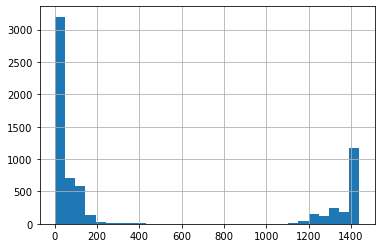

In [11]:
# look at distribution of how many 0 volume minute
(fx['volume'] == 0.).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [12]:
# let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 200).index
fx = fx.loc[voluminous_index]

In [13]:
# quick sanity check of data 
fx.between_time('21:59', '22:01')

,close,high,low,open,volume,day,ordinal_day
datetime,,,,,,,
2005-01-02 21:59:00,1.35475,1.35475,1.35475,1.35475,0.0,6,1
2005-01-02 22:00:00,1.35475,1.35475,1.35475,1.35475,0.0,0,2
2005-01-02 22:01:00,1.35475,1.35475,1.35475,1.35475,0.0,0,2
2005-01-03 21:59:00,1.34640,1.34650,1.34630,1.34650,6.0,0,2
2005-01-03 22:00:00,1.34650,1.34660,1.34640,1.34640,7.0,1,3
...,...,...,...,...,...,...,...
2023-02-14 22:00:00,1.07348,1.07348,1.07348,1.07348,0.0,2,6619
2023-02-14 22:01:00,1.07348,1.07348,1.07348,1.07348,0.0,2,6619
2023-02-15 21:59:00,1.06872,1.06872,1.06872,1.06872,0.0,2,6619


# Normalizing inputs analysis

In [14]:
# demean close by subtracting from previous minute
normal = (fx['close'] - fx['close'].shift(1)) / fx['close'].shift(1)

# zero out if the previous minute came from skip in days (makes very little difference in distribution)
# skips = ((fx['ordinal_day'] - fx['ordinal_day'].shift(1)) > 1)
# normal.loc[skips] = 0

normal = normal / normal.std()
normal = normal.fillna(0)

## Especially since financial data is very very fat tailed, a squashing function seems desirable to help keep inputs within distribution

[]

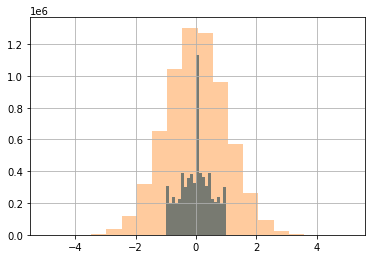

In [15]:
ax = np.tanh(normal).hist(bins = 20)
ax.hist(np.random.normal(size = len(normal)), bins = 20, alpha = .4)
ax.plot()

compared to the normal distribution in orange, the tail distribution looks quite off. Let's changes the squashing factor of the tanh

[]

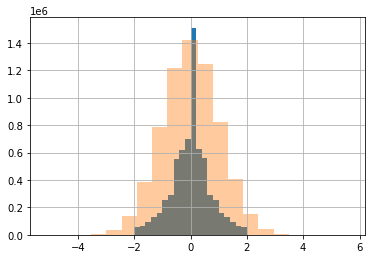

In [16]:
squash_factor = 2
ax = (squash_factor * np.tanh(normal / squash_factor)).hist(bins = 20)
ax.hist(np.random.normal(size = len(normal)), bins = 20, alpha = .4)
ax.plot()

[]

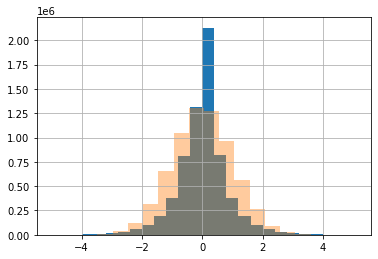

In [17]:
squash_factor = 4
ax = (squash_factor * np.tanh(normal / squash_factor)).hist(bins = 20)
ax.hist(np.random.normal(size = len(normal)), bins = 20, alpha = .4)
ax.plot()

squash factor of 4 seems to have the most natural looking tail distribution that about lines up with normal (not a rigorous analysis, but ultimately this should be a pretty minor hyperparameter)

# Leverage Analysis

In [18]:
periods = [5, 10, 15, 20, 30, 45, 60, 90, 120]

# let's just arbitrary say there should be less than 400 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 400).index
fx = fx.loc[voluminous_index]

# calculate future deltas
futures = {}
for i in periods:
    futures_name = f'future_diff{i}'
    future_diff = (fx['close'].shift(-i) - fx['close']) / fx['close']
    futures[futures_name] = future_diff

futures_df = pd.DataFrame(futures)
future_cols = futures_df.columns
fx = pd.concat((fx, futures_df), axis = 1)

# clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
overnight_masks = {}
fx['day_break'] = ((fx['day'] != (fx['day']).shift(-1)) & (fx['day'] != (fx['day'] - 1).shift(-1)))
broken_days = fx[fx.groupby('ordinal_day')['day_break'].transform('any')]
for i in periods:
    futures_name = f'future_diff{i}'
    no_futures = broken_days.between_time(f'{21 - i // 60}:{59 - i % 60}', '21:59').index
    fx.loc[no_futures, futures_name] = 0

0.17397951978079285

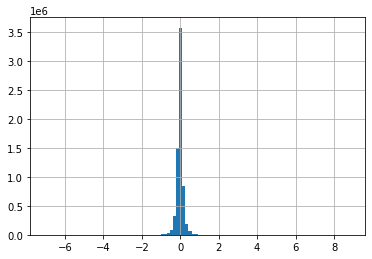

In [19]:
lev_5 = 500 * fx['future_diff5']
lev_5.hist(bins = 100)
lev_5.std()

0.41519973550789163

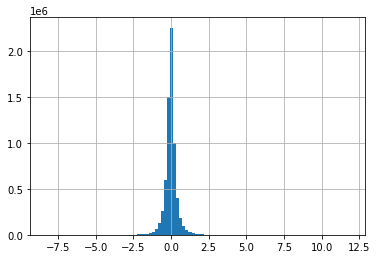

In [20]:
lev_30 = 500 * fx['future_diff30']
lev_30.hist(bins = 100)
lev_30.std()

0.8239297477260055

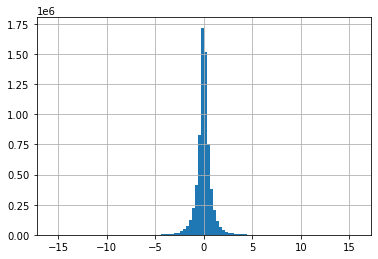

In [21]:
lev_120 = 500 * fx['future_diff120']
lev_120.hist(bins = 100)
lev_120.std()